In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math 
import scipy 
import scipy.stats

cdf = scipy.stats.norm.cdf
T = 3/12
T_mat = 5 + T
K = 0.805
r0 = 0.042
theta = 5/100
sigma = 1/100
k = 0.15

In [2]:
"""  Analytical Method """

def B(tau, k):
    return (1 - np.exp(-k*tau))/k

def A(tau, sigma, theta, k):
    b = B(tau,k)
    firstTerm = (theta - (sigma**2)/(2 * k**2))*(b - tau)
    secondTerm = (sigma**2)/(4*k) * b**2
    return np.exp(firstTerm - secondTerm)
    
def bond(r0, t, T, sigma, theta, k):
    tau = T - t
    return A(tau, sigma, theta, k)*np.exp( - B(tau,k) * r0)

def analytical(t, T1, T2, K):
    sigma_tilde = sigma * np.sqrt( (1 - np.exp(-2*k*T1))/(2*k) ) * B(T2 - T1, k)
    p_T2 = bond(r0, t, T2, sigma, theta, k)
    p_T1 =  bond(r0, t, T1, sigma, theta, k)
    h = (sigma_tilde)**(-1) * np.log(p_T2 /(p_T1 * K)) + sigma_tilde/2
    return K * p_T1 * cdf(-h + sigma_tilde) - p_T2*cdf(-h)


#analytical solution
price = analytical(t = 0, T1 = T , T2 = T_mat, K = K)
print(f"Analytical solution: {np.round(price, 8)}")

Analytical solution: 0.0074898


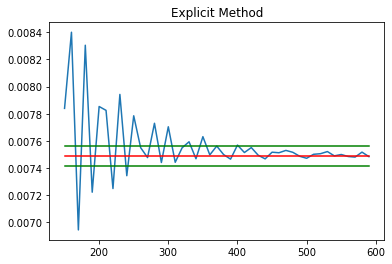

In [3]:
""" Explicit Method """
rmin = 0
rmax = 1

def create_grid(r_min, r_max, Nr, T, Nt):
        dr = r_max / Nr
        dt = T / Nt
        tval = np.arange(0, T, dt)
        rval = np.arange(r_min, r_max, dr)
        return dt, dr, tval, rval, np.empty((len(rval), len(tval)))
    

def getprice(V, rv, r0):
        """
        return the price connected to v0, if it is not inside the grid we use interpolation
        """
        
        ispresent = np.any( rv == r0 )
        if ispresent: 
            return V[np.where(rv==r0)[0], 0].item()
        else:
            dist = np.abs(rv - r0)
            min_index, min_dist = np.argmin(dist), np.min(dist)
           
            if  rv[min_index] > r0:
                min_index2 = min_index - 1 
                return V[min_index2, 0] + (r0 - rv[min_index2])*(V[min_index, 0] -  V[min_index2, 0])/(rv[min_index]  - rv[min_index2]   )
                
            else:
                min_index2 = min_index + 1
                return V[min_index, 0] + (r0 - rv[min_index])*(V[min_index2, 0] -  V[min_index, 0])/(rv[min_index2]  - rv[min_index] )  
                

        
        
def explicitmethod(Nr, Nt = 100, r_max = rmax, r_min = rmin):
    
    #create the grid containg also final time and time equal to 0 and initial space value  
    dt, dr, tv, rv, V = create_grid(r_min, r_max, Nr, T, Nt)
    #for high value of the IR then the value of the option must be equal to the payoff discounted 
    V[-1, :] =  - bond(rv[-1],tv, T_mat, sigma, theta, k) + K*bond(rv[-1], tv , Nt*dt ,sigma, theta, k)
    
    #for r = 0 then the option is always OTM 
    V[0, :] = 0
    #for t = T then we just have the final payoff
    V[:, -1] = np.maximum(  K - bond(rv, T, T_mat, sigma, theta, k), 0 )
    
    #calculate coefficient of the equation
    rvec = rv[1:-1]
    a = -dt*k*0.5*(theta-rvec)/dr + (sigma**2*dt*0.5/dr**2)
    b = 1 - (sigma**2*dt/dr**2) - (dt*rvec)
    c = a + (dt*k*(theta-rvec)/dr)
   
    for j in np.flip(np.arange(0,Nt-1)):
        #we exclude the last because we already know the value
        V[1:-1, j] =  b*V[1:-1, j+1] + a*V[:-2, j+1] +  c*V[2:, j+1]
    
    return  getprice(V,rv, r0)



Nr_list = np.arange(150,600, 10)
prices = [explicitmethod( j , Nt=100) for j in Nr_list]
analytical = [price for j in Nr_list]
#plot the result while changing the value for Nr
plt.plot(Nr_list, prices)
plt.plot(Nr_list, analytical, color = "red")
plt.plot(Nr_list, [1.01*j for j in analytical] , color = "green")
plt.plot(Nr_list, [0.99*j for j in analytical] , color = "green")
plt.title("Explicit Method")
plt.show()

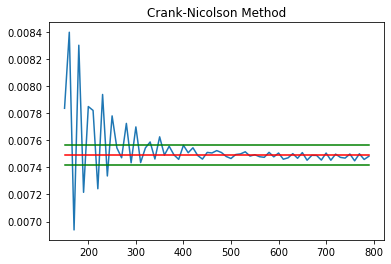

In [9]:
""" Crank-Nic Method """
from scipy.sparse import csc_matrix
rmin = 0
rmax = 1
Nr = 200
Nt = 50

def TDMAsolver(a, b, c, d):
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.copy, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        #last value here is nf-1
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
    
    x = np.copy(bc)
    x[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        x[il] = (dc[il]-cc[il]*x[il+1])/bc[il]

    return x




def crank_nic(Nr, Nt = 120, r_max = rmax, r_min = rmin, method = "thomas"):
    
    #create the grid containg also final time and time equal to 0 and initial space value  
    dt, dr, tv, rv, V = create_grid(r_min, r_max, Nr, T, Nt)
    #for high value of the IR then the value of the option must be equal to the payoff discounted 
    V[-1, :] =  - bond(rv[-1],tv, T_mat, sigma, theta, k) + K*bond(rv[-1], tv , Nt*dt ,sigma, theta, k)

    #for r = 0 then the option is always OTM 
    V[0, :] = 0
    #for t = T then we just have the final payoff
    V[:, -1] = np.maximum(  K - bond(rv, T, T_mat, sigma, theta, k), 0 )

    alpha = lambda r: k*(theta - r)/2
    
    rvec = rv[1:-1]
    #calculating the matrix M2
    main_diagonal_star =  -1/dt + 0.5*sigma**2/dr**2 + 0.5*rv[1:-1]
    upper_diagonal_star = -alpha(rvec)/(2*dr)  -  sigma**2*0.25*(1/dr**2)
    lower_diagonal_star = alpha(rvec)/(2*dr) - sigma**2*0.25*(1/dr**2)
    M2 = np.diag(main_diagonal_star) + np.diag(lower_diagonal_star[1:], -1) + np.diag(upper_diagonal_star[:-1], 1)

    
    #calculating the matrix M1
    main_diagonal =  -1/dt - 0.5*sigma**2/dr**2 -0.5*rvec
    upper_diagonal = -upper_diagonal_star
    lower_diagonal =  -lower_diagonal_star
    if method == "None":
        M1 = np.diag(main_diagonal) + np.diag(lower_diagonal[1:], -1) + np.diag(upper_diagonal[:-1], 1)
     
    for j in np.flip(np.arange(0,Nt-1)):
        #we exclude the last because we already know the value
        b = np.zeros((M2.shape[0], 1))   
        b[0] = - lower_diagonal[0] * V[0, j] + V[0, j+1] * lower_diagonal_star[0]
        b[-1] = - upper_diagonal[-1] * V[-1, j] +  V[-1, j+1] * upper_diagonal_star[-1] 
        
        #solving the system
        if method == "Thomas":
            V[1:-1, j] = TDMAsolver(lower_diagonal[1:], main_diagonal, upper_diagonal[:-1], (M2 @ V[1:-1, j+1].reshape(-1,1) + b).flatten())
        elif method == "None":
            V[1:-1, j] = np.linalg.solve(M1, (M2 @ V[1:-1, j+1].reshape(-1,1) + b )).flatten()
    
    return  getprice(V,rv, r0)



Nr_list = np.arange(150,800, 10)
prices = [crank_nic( j , Nt = 100, method = "Thomas") for j in Nr_list]
analytical = [price for j in Nr_list]
#plot the result while changing the value for Nr
plt.plot(Nr_list, prices)
plt.plot(Nr_list, analytical, color = "red")
plt.plot(Nr_list, [j + j*0.01 for j in analytical] , color = "green")
plt.plot(Nr_list, [j - j*0.01 for j in analytical] , color = "green")
plt.title("Crank-Nicolson Method")
plt.show()


